# Fourier Series Approximation

The goal of this notebook is to compute the Fourier Series approximation of a function f(x). As a reminder, for some function f(x), the Fourier Series approxmiation is:

$$
f(x) = \frac{A_0}{2} + \sum_{k=1}^{\infty} A_k \cdot \cos(\frac{2 \pi k x}{L}) + B_k \cdot \sin(\frac{2 \pi k x}{L})
$$
$$
A_k = \langle f(x), \cos(\frac{2 \pi k x}{L}) \rangle  = \frac{2}{L} \int_{0}^L f(x) \cdot \cos(\frac{2 \pi k x}{L}) dx
$$
$$
B_k = \langle f(x), \sin(\frac{2 \pi k x}{L}) \rangle = \frac{2}{L} \int_{0}^L f(x) \cdot \sin(\frac{2 \pi k x}{L}) dx \\
$$

Intuitively speaking, we are using the fact that $\cos$ and $\sin$ form an orthonormal basis for periodic functions on a defined interval to calculate how much of the basis is present $f(x)$ and then summing those components up to compute the approximation. It's almost like you have some set of basis vectors, and to compute a particular vector in the vector space you sum some coefficient * basis vector to form the vector.


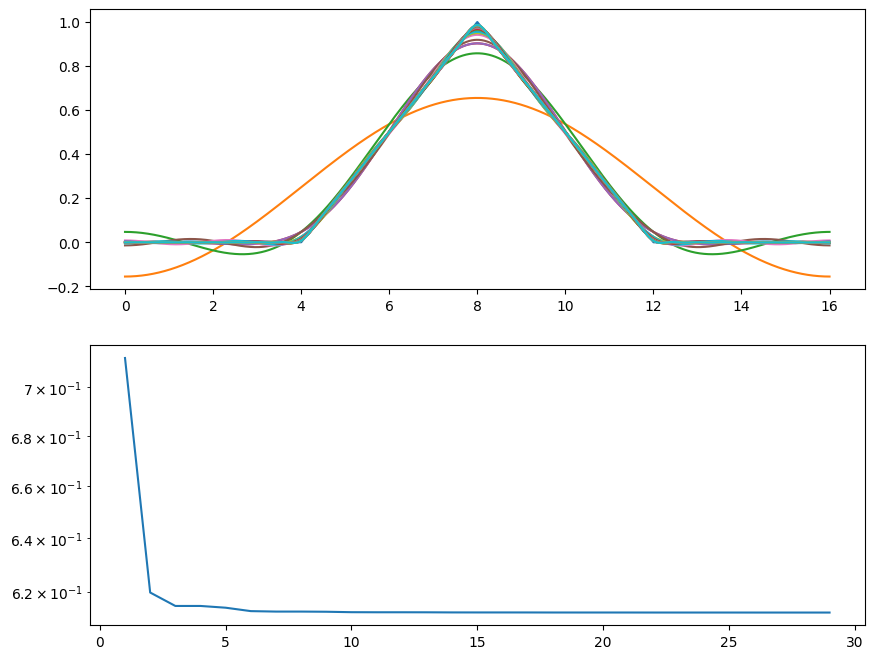

<Figure size 640x480 with 0 Axes>

In [1]:
# Overall Plan:
# - Define the hat function
# - Iterate through n iterations
# -- Compute the coefficients
# -- Compute the Fourier Series
# - Plot the hat function, and all n iterations of the Fourier approximation

import numpy as np
import matplotlib.pyplot as plt

L = 16
dx = 1e-3 # spacing
num_samples = int(L/dx)
x = np.linspace(0, L, num_samples) 

def f(x: np.ndarray, L: float) -> np.ndarray:
    output = np.zeros_like(x)
    rising_mask = (x >= L/4) & (x < L/2) 
    falling_mask = (x >= L/2) & (x < 3*L/4)
    # These were analytically calculated via y = mx + c
    output[rising_mask] = (4/L) * x[rising_mask] - 1
    output[falling_mask] = 3 - (4*x[falling_mask]/L)
    return output


def fourier_series_approximation(x: np.ndarray, f_values: np.ndarray, iterations: int, L: int, dx: float) -> np.ndarray:
    approximation = np.zeros_like(x)

    # Implement a vectorized coefficient calculation
    k = np.arange(1, iterations+1, 1)
    X, K = np.meshgrid(x, k)
    A_arr = np.sum(np.cos((2 * np.pi * X * K) / L) * f_values * dx * (2/L), axis=1)
    B_arr = np.sum(np.sin((2 * np.pi * X * K) / L) * f_values * dx * (2/L), axis=1)

    def A_k(k: int):
        return np.sum(np.cos(2*np.pi*k*x*(1/L)) * f_values * dx) * (2/L)
    
    # def B_k(k: int):
    #     return np.sum(np.sin(2*np.pi*k*x*(1/L)) * f_values * dx) * (2/L)

    A_0 = A_k(0) / 2
    for i in range(1, iterations+1): # Include the last iteration
        A = A_arr[i-1]
        B = B_arr[i-1]
        k_approximation = A * np.cos(2*np.pi*i*x*(1/L)) + B * np.sin(2*np.pi*i*x*(1/L))
        approximation += k_approximation

    err = np.linalg.norm(f_values - approximation) / np.linalg.norm(f_values)
    return A_0 + approximation, err 


f_values = f(x, L)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.figure()
ax1.plot(x, f_values, '-')

errors = []
for i in range(1, 30):
    approx, err = fourier_series_approximation(x, f_values, i, L, dx)
    errors.append(err)
    ax1.plot(x, approx, '-')
ax2.semilogy(np.arange(1, len(errors) + 1, 1), errors, '-')
plt.show()





# Gibbs Phenomena

As more Fourier series constituents or components are taken, the Fourier series shows the first overshoot in the oscillatory behavior around the jump point approaching ~ 9% of the (full) jump and this oscillation does not disappear but gets closer to the point so that the integral of the oscillation approaches zero.

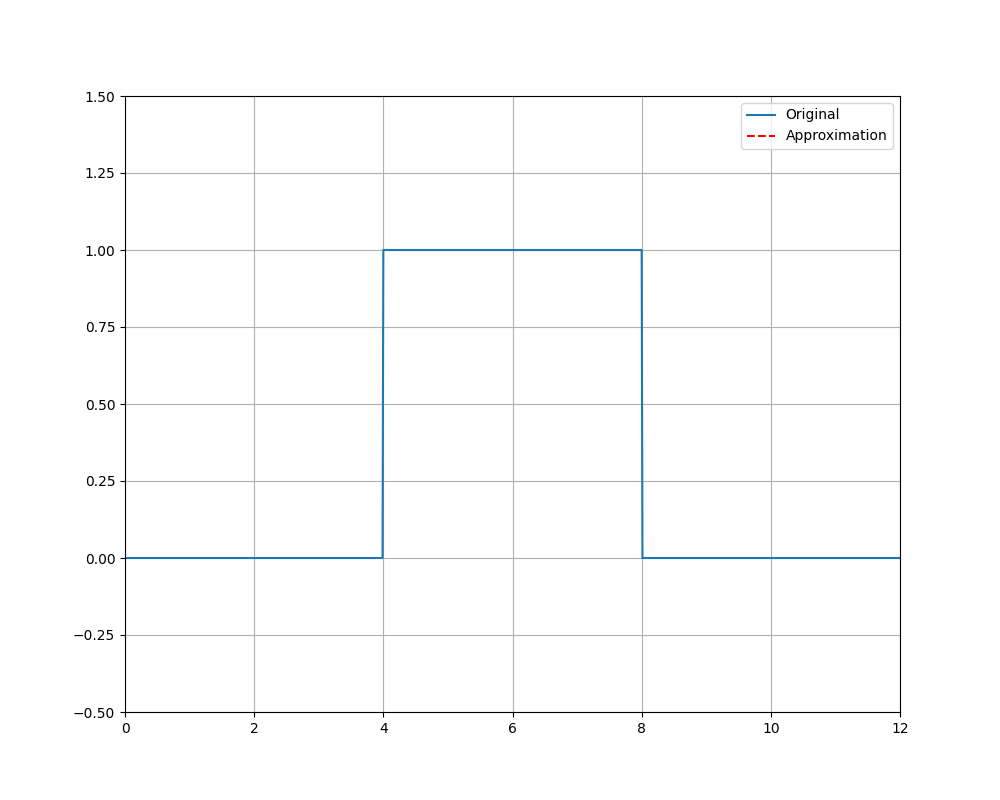

In [2]:
from matplotlib.animation import FuncAnimation
from typing import Iterable
from matplotlib.lines import Line2D
%matplotlib widget

domain_size = 12
samples = 1000
dx = domain_size/samples
x = np.linspace(0, domain_size, samples)
f_values = np.zeros(samples)
mask = (x >= domain_size//3) & (x <= 2*domain_size//3)
f_values[mask] = 1


num_frames = 100
frames = np.zeros((num_frames, samples))
for i in range(1, num_frames):
    approx, err = fourier_series_approximation(x, f_values, i, domain_size, dx)
    frames[i, :] = approx


def create_animation(animation_frames: np.ndarray):
    fig, ax = plt.subplots(figsize=(10, 8))
    f_plot, = ax.plot(x, f_values, '-', label = "Original")
    approx_plot, = ax.plot([], [], 'r--', label = "Approximation")

    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(f_values) - 0.5, np.max(f_values) + 0.5)
    ax.legend()
    ax.grid(True)

    def init() -> Iterable[Line2D]:
        approx_plot.set_data([], [])
        return approx_plot,
    
    def animate(i):
        approx_plot.set_data(x, animation_frames[i, :])
        return approx_plot,
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=animation_frames.shape[0], interval=100, blit=True)
    plt.show()
    return anim

anim = create_animation(frames)
anim


